#Задача: Определить пол клиентов

Это решение расположено в репозитории https://github.com/crazyelf1971/odb21/

##Описание задачи

https://open-data-battle.geecko.com/issues/gender

В одной компании произошла неприятность: случился потоп, в бумажных анкетах клиентов размыло некоторые строки и в 1000 анкетах пострадало поле “gender”. Конечно, их было бы можно восстановить, но в компании решили автоматизировать решение проблемы и определить пол клиентов по фотографиям. Был создан датасет gender.csv, в котором записаны признаки человека на фото и его пол.

Первые 1000 значений имеют пропуски в столбце gender.

Все столбцы с ".1" в названии дублируют предыдущие столбцы без ".1", но содержат уникальные значения

Необходимо произвести чистку данных:

Присоединить дублирующие столбцы к основным.
Столбцы 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair' содержат информацию в условных единицах. Известно, что измерения проводились разными людьми с разными измерительными инструментами, поэтому данные в столбцах имеют разную погрешность измерений. Необходимо уменьшить влияние погрешности путем приравнивания значений диапазона [0,0.5) к 0, а [0.5, 1) —- к 1. Столбцы 'orehead_width_cm' и 'forehead_height_cm' необходимо оставить «как есть».
Оставить один из дублирующих друг друга столбцов.
Определите пол по остальным параметрам из выборки для первой тысячи значений и прикрепите его в CSV формате. Файл должен содержать только прогнозные значения в формате "Male"/"Female", в одном столбце без заголовка

Пороговое значение для данной задачи классификации считать равным 0.5.

Для успешного прохождения достаточно иметь 70% точность решения

Обратите внимание, что в таблице не должно быть пустых значений. Проверяйте файл решения через Блокнот, Notepad++ или их аналоги на отсутствие пустой строки в конце решения!

##Скачивание данных

Если ссылка на соревнование перестанет быть актуальной, можно будет взять файлы из моего репозитория с решениями https://github.com/crazyelf1971/odb21  
При запуске не из Google Colab можно использовать для скачки библиотеку wget и вызовы os.system, либо просто взять готовый csv файл из репозитория и пропустить этот шаг.

In [2]:
import gdown

file_name = gdown.download('https://open-data-battle.geecko.com/dataset/gender.zip',None, False)
!unzip {file_name}
!ls -la *.csv

Downloading...
From: https://open-data-battle.geecko.com/dataset/gender.zip
To: /content/gender.zip
276kB [00:00, 1.68MB/s]


Archive:  gender.zip
  inflating: gender (1).csv          
  inflating: __MACOSX/._gender (1).csv  
-rw-r--r-- 1 root root 714491 Aug 30 10:19 'gender (1).csv'


##Загрузка данных

In [117]:
import pandas as pd

# загрузка данных из файла
df = pd.read_csv('gender (1).csv', index_col=0)
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 0 to 2514
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                2515 non-null   int64  
 1   long_hair                            2515 non-null   float64
 2   forehead_width_cm                    2515 non-null   float64
 3   forehead_height_cm                   2515 non-null   float64
 4   forehead_width_mm                    2515 non-null   float64
 5   forehead_width_conventional_units    2515 non-null   float64
 6   nose_wide                            2515 non-null   float64
 7   nose_long                            2515 non-null   float64
 8   lips_thin                            2515 non-null   float64
 9   distance_nose_to_lip_long            2515 non-null   float64
 10  gender                               1514 non-null   object 
 11  index.1                       

,index,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender,index.1,long_hair.1,forehead_width_cm.1,forehead_height_cm.1,forehead_width_mm.1,forehead_width_conventional_units.1,nose_wide.1,nose_long.1,lips_thin.1,distance_nose_to_lip_long.1,gender.1
0,0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN,2515,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN,2516,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN,2517,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN,2518,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN,2519,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


##Подготовка данных

Основная сложность тут была понять, для чего нужны колонки `*.1` в правой части датасета, и что с ними нужно сделать. Их нужно отделить, практически "распилив" датасет вертикально пополам, и пристыковать снизу к основным данных. При этом в этой правой части есть строки, полностью состоящие из `NA`, их нужно просто удалить. Колонки `index` и `index.1` - сквозной индекс через обе части датасета.  
Шаги подготовки данных:  
- делим датасет на две части по вертикали
- убираем .1 из названий колонок правой части
- убираем пустые строки из правой части
- объединяем две части вертикально в один датасет
- убираем лишние признаки
- бинаризируем признаки из списка в описании задачи
- кодируем пол числами
- делим данные на трейн и тест

Нормализация данных не делалась, и без неё качества предсказаний оказалось достаточно, чтобы результат был принят.

In [118]:
# делим таблицу на две части вертикально
extra_columns = df.columns.str.contains('.1')
df1 = df.loc[:, ~extra_columns]
df2 = df.loc[:, extra_columns]
# убираем .1 из названий колонок
df2.columns = [col.split('.')[0] for col in df2.columns]
# проверка, что список колонок обеих частей совпадает
assert (df1.columns == df2.columns).all()
# убираем пустые строки из правой части
df2 = df2[~df2.gender.isna()]
# объединяем части
df = pd.concat([df1,df2], ignore_index=True)
# убираем лишние колонки - индекс и дублирующуюся колонку в других единицах
df = df.drop(columns=['index', 'forehead_width_mm'])
# бинаризация столбцов по threshold=0.5
columns_binary = ['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair']
df[columns_binary] = (df[columns_binary] >= 0.5).astype(int)
# разделение train/test
df_train = df.loc[~df.gender.isna()].copy()
df_test = df.loc[df.gender.isna()].copy()
# цифровое кодирование пола
gender2int = {'Female': 1, 'Male': 2}
int2gender = {1: 'Female', 2: 'Male'}
df_train['gender'] = df_train.gender.map(gender2int)
# создаём матрицу X и вектор y для обучения
X = df_train.drop(columns='gender')
y = df_train.gender
print(f'Размер данных для обучения: {X.shape}')

Размер данных для обучения: (4000, 8)


##Решение задачи

- в качестве модели используем логистическую регрессию с кросс-валидацией
- предсказания из числовой формы переводим обратно в названия полов
- сохраняем результат в `csv` файл, учитывая требования из описания - без заголовка и без индексов

In [119]:
from sklearn.linear_model import LogisticRegressionCV

# тренировка модели
lr = LogisticRegressionCV(n_jobs=-1, cv=5)
lr.fit(X, y)

# предсказания
preds = lr.predict(df_test.drop(columns='gender'))

# предсказания в строковой форме
df_test['gender'] = [int2gender[x] for x in preds]

# вывод в файл согласно требований
result = df_test[['gender']]
result.to_csv('gender_predict.csv', header=False, index=False)

##Анализ и визуализация качества предсказаний модели

Можно сделать такие выводы:  
- качество тренировки модели по фолдам очень хорошее, в среднем 0.97, отклонение 0.01
- в основном на предсказание влияют 4 признака
- соотношение полов в трейне и в тесте примерно одинаковое

Примечание: нужно учитывать, что без масштабирования данных коэффициенты линейной регрессии не всегда пропорциональны важности признаков.

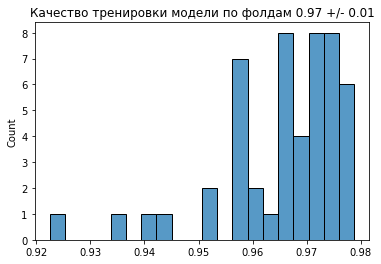

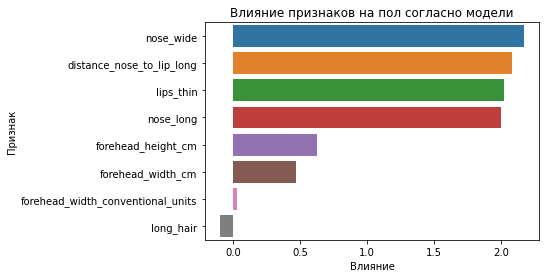

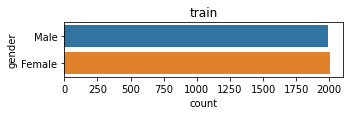

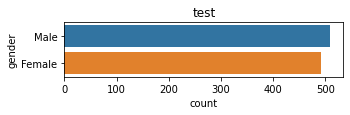

In [116]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# качество тренировки модели
plt.figure()
model_score = np.array(list(lr.scores_.values())).flatten()
sns.histplot(model_score, bins=20);
plt.title(f'Качество тренировки модели по фолдам {model_score.mean():0.2f} +/- {model_score.std():0.2f}');

# влияние признаков
plt.figure()
importance = pd.DataFrame({'Влияние': lr.coef_[0], 'Признак': X.columns})
sns.barplot(x='Влияние', y='Признак', data=importance.sort_values('Влияние', ascending=False));
plt.title('Влияние признаков на пол согласно модели');

# соотношение полов в трейне и в тесте
plt.figure(figsize=(5, 1));
sns.countplot(y='gender', data=df[['gender']]);
plt.title('train');

plt.figure(figsize=(5, 1));
sns.countplot(y='gender', data=df_test[['gender']]);
plt.title('test');

#Визуализация корреляции признаков с полом

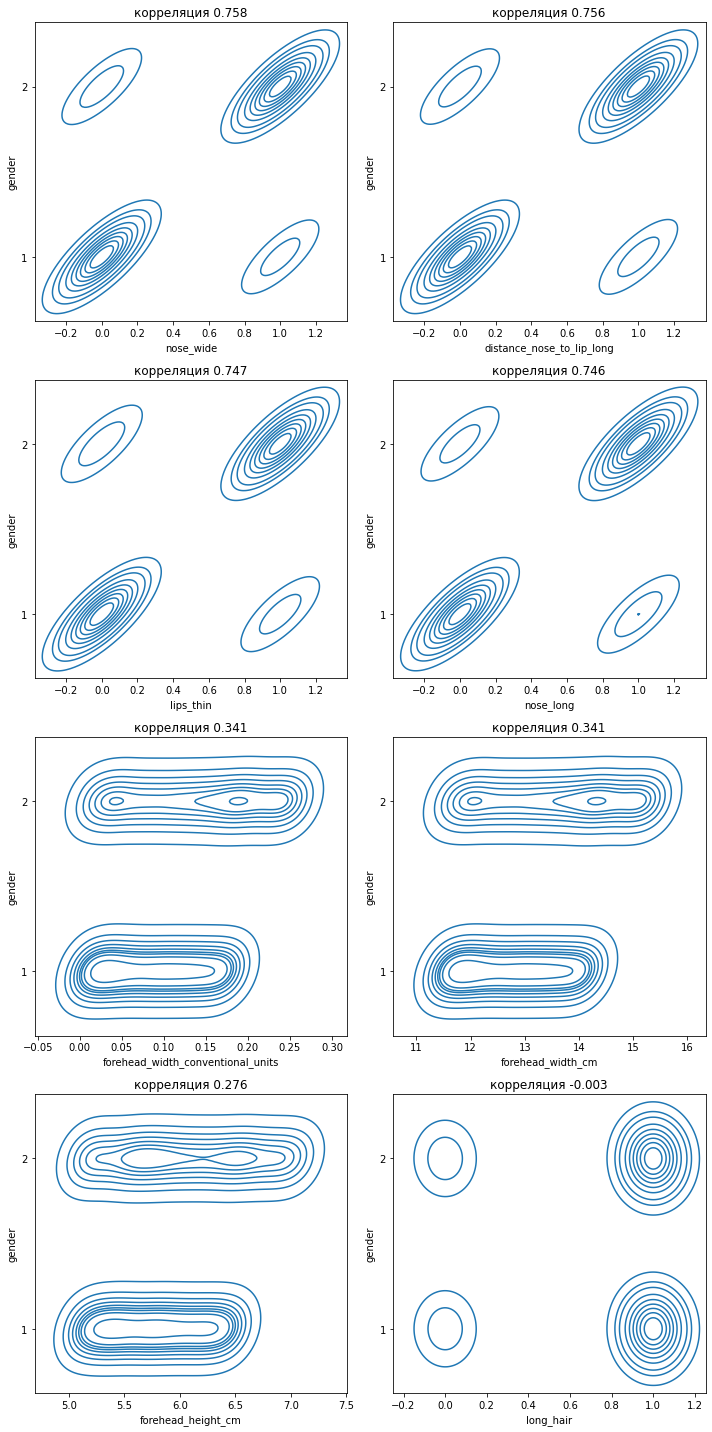

In [81]:
corr_gender = df_train.corr()['gender'].sort_values(ascending=False)
y_ticks = df_train.gender.unique()
fig, axs = plt.subplots(4, 2, figsize=(10, 20));
for i, col in enumerate(corr_gender.index, -1):
    ax = axs[i // 2][i % 2]
    if col == 'gender':
        continue
    sns.kdeplot(x = col, y = 'gender', data=df_train, ax=ax);
    ax.set_yticks(y_ticks)
    ax.set_title(f"корреляция {corr_gender[col]:0.3f}");

fig.tight_layout();